First we load the data, the models, and their return predictions.

We add a day to the df index because:
1. when we stored the test_predictions, we used the last N days of available data.
2. this means that we predict the last N-1 days and the day after.

# TODO

## ADD TUSDT, XRPUSDT instead of UNIUSDT (better coinindex)

## Show a colormap plotting of meanvariance weights and window sizes (and how they perform compared to the markowitz model)

## Uniform buy and hold

## Currently running with sentiment score. Try without

In [44]:
tickers = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "XRPUSDT"]

import pandas as pd
import joblib
%store -r test_predictions
pred_close = pd.DataFrame(test_predictions)
pred_close.index = pred_close.index + pd.Timedelta(days=1)

for ticker in tickers:
    scaler = joblib.load(f"scalers/{ticker}_scaler.pkl")
    seventeen_columns = pd.concat([pred_close[ticker]] * 17, axis=1)

    pred_close[ticker] = scaler.inverse_transform(seventeen_columns)[:, 0]

def calculate_cumulative_returns(df):
    portfolio_returns = np.array([
        np.dot(true_returns.loc[date], df.loc[date]) for date in df.index
    ])
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns = pd.DataFrame(cumulative_returns, index=df.index, columns=["cumu"])
    cumulative_returns["port"] = portfolio_returns
    return cumulative_returns



In [9]:
pred_close

,SOLUSDT,BTCUSDT,ETHUSDT,DOGEUSDT,XRPUSDT
Open time,,,,,
2023-08-15,27.841843,29313.488281,1995.421143,0.072535,0.600947
2023-08-16,28.552631,29390.787109,1969.292358,0.072887,0.608126
2023-08-17,27.675592,29202.623047,1954.579468,0.071825,0.610257
2023-08-18,26.293097,28976.105469,1936.386719,0.070277,0.600276
2023-08-19,24.587820,27821.833984,1963.721069,0.068505,0.605385
...,...,...,...,...,...
2023-12-28,97.676933,41158.812500,2254.713623,0.086840,0.621751
2023-12-29,95.907036,41842.203125,2335.135498,0.087053,0.623574
2023-12-30,92.450928,41612.511719,2345.423584,0.086399,0.625698


In [10]:
import data
import pandas as pd, numpy as np

if "USDT" in tickers: tickers.remove("USDT")
dfs = [data.load_asset(ticker, sampling="1d") for ticker in tickers]
dfs = [data.subset(df, start=pd.Timestamp('2021-01-01'), end=pd.Timestamp('2024-01-03')) for df in dfs]
dfs = [data.add_returns(df) for df in dfs]
dfs = [df.dropna() for df in dfs]

opens = pd.concat([df["Open"] for df in dfs], axis=1, keys=tickers)

true_returns = pd.concat(
    [df["Return"].reindex(pred_close.index) for df in dfs], 
    axis=1,
    keys=tickers
)

C:\Users\ic2594\AppData\Local\Temp\ipykernel_14244\1786670753.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (asset_vols[i], mean_returns[i]), fontsize=8)


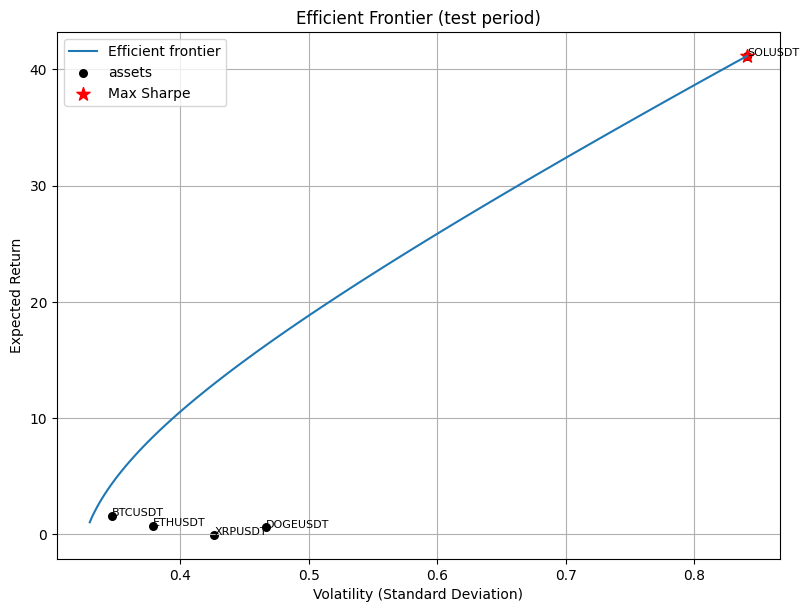

In [45]:
import matplotlib.pyplot as plt, numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import plotting


test_opens = opens[pd.Timestamp('2023-08-14'):]

mean_returns = expected_returns.mean_historical_return(test_opens, frequency=365)
cov_matrix = risk_models.sample_cov(test_opens)
ef = EfficientFrontier(mean_returns, cov_matrix)
fig, ax = plt.subplots(figsize=(8, 6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)


# Compute individual asset volatility (sqrt of diagonal of covariance matrix)
asset_vols = np.sqrt(np.diag(cov_matrix))

# Plot individual assets
for i, txt in enumerate(test_opens.columns):
    ax.annotate(txt, (asset_vols[i], mean_returns[i]), fontsize=8)
    # ax.scatter(asset_vols[i], mean_returns[i], marker="o", color="gray", alpha=0.6)


ef = EfficientFrontier(mean_returns, cov_matrix)
max_sharpe_weights = ef.max_sharpe()
max_sharpe_return, max_sharpe_volatility, _ = ef.portfolio_performance()
ax.scatter(max_sharpe_volatility, max_sharpe_return, marker="*", color="r", s=100, label="Max Sharpe")

plt.title("Efficient Frontier (test period)")
plt.xlabel("Volatility (Standard Deviation)")
# Mark the max-sharpe portfolio
ax.legend()
plt.ylabel("Expected Return")
plt.grid()
plt.show()

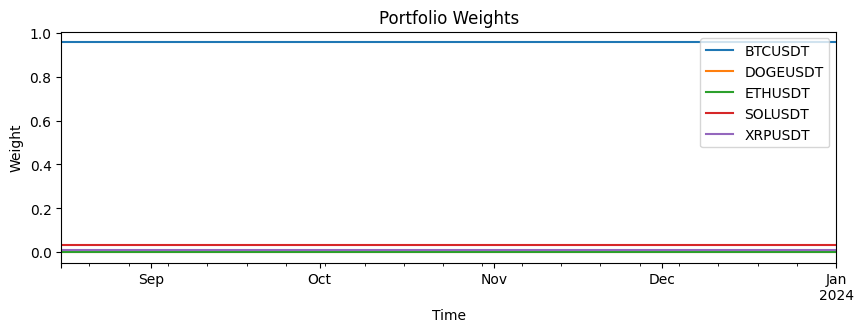

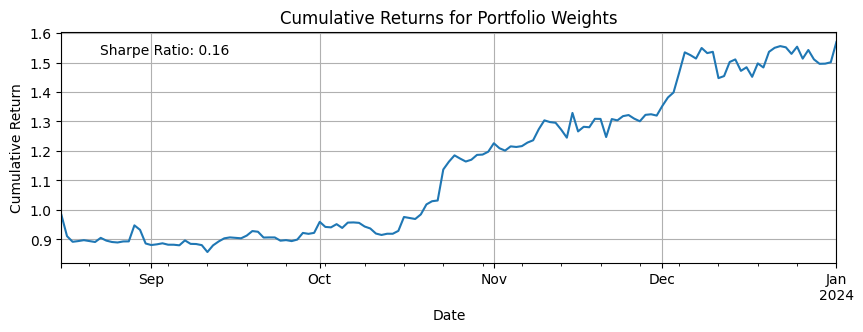

In [48]:
portfolio_returns = []
portfolio_weights = []
start_date = current_date = pd.Timestamp('2023-08-14')
data_up_to_today = opens.loc[:current_date]

# Calculate expected returns and covariance matrix using the latest data
mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
cov_matrix = risk_models.sample_cov(data_up_to_today)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe(risk_free_rate=-10)
cleaned_weights = ef.clean_weights()

# Get returns for the current day (next day's returns based on today's weights)
daily_returns = pd.DataFrame(
    {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
    index=[current_date]
).loc[current_date]

for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    if current_date > pd.Timestamp('2023-12-31'): break
    weights["day"] = current_date + pd.Timedelta(days=1)
    portfolio_weights.append(weights.copy())

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
# plt.show()
plt.close()

portfolio_weights = pd.DataFrame(portfolio_weights)
portfolio_weights.index = portfolio_weights["day"]
portfolio_weights.drop(columns=["day"], inplace=True)



fig, ax = plt.subplots(figsize=(10, 3))
portfolio_weights.plot(ax=ax, title="Portfolio Weights")
ax.set_xlabel("Time")
ax.set_ylabel("Weight")
ax.legend(loc="upper right")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Plot cumulative returns for the portfolio_weights
cumulative_returns = calculate_cumulative_returns(portfolio_weights)

fig, ax = plt.subplots(figsize=(10, 3))
cumulative_returns["cumu"].plot(ax=ax, title="Cumulative Returns for Portfolio Weights")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")

# Calculate and display the Sharpe Ratio
if cumulative_returns["port"].std() < 1e-15:
    sharpe_ratio = np.nan
else:
    sharpe_ratio = cumulative_returns["port"].mean() / cumulative_returns["port"].std()
ax.text(0.05, 0.95, f"Sharpe Ratio: {sharpe_ratio:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.grid()
plt.show()


Now we calculate the Markowitz weights

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


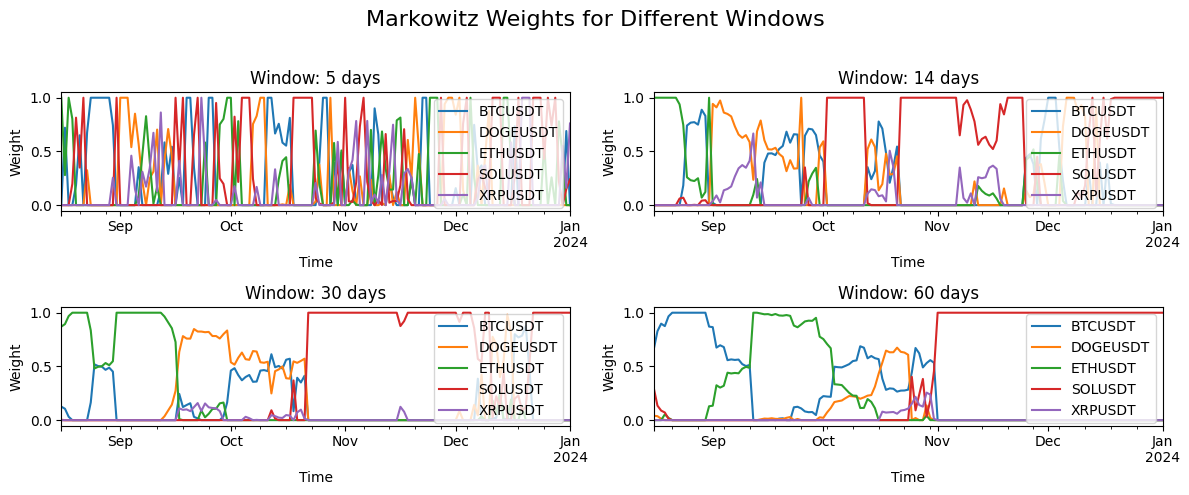

In [ ]:
MarkMVO = []
MarkMVO_windows = PredMVO1_windows # windows = [30, 180, 480, 9999]
# MarkMVO_windows = windows = [30, 180, 480, 9999]
for window in MarkMVO_windows:
    portfolio_returns = []
    portfolio_weights = []
    start_date = pd.Timestamp('2023-08-14')

    # Iterate through each day after March 1, 2024
    for current_date in dfs[-1].index[dfs[-1].index > start_date]:
        if current_date > pd.Timestamp('2023-12-31'): break
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        weights["day"] = current_date + pd.Timedelta(days=1)

        # Calculate portfolio return using today's weights
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)

    # Convert portfolio returns into a DataFrame with appropriate index
    # portfolio_returns_df = pd.DataFrame(portfolio_returns, index=pd.date_range(start=start_date, periods=len(portfolio_returns), freq='D'), columns=['Portfolio Return'])

    # Plot the portfolio returns
    # (1 + portfolio_returns_df).cumprod().plot(figsize=(10, 6), title="Cumulative Portfolio Returns")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # plt.show()
    plt.close()

    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    MarkMVO.append(portfolio_weights)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(MarkMVO):
        MarkMVO[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

There are a number of ways that we can incorporate prediction in the optimization program.

1. Use the predictions to augment the "historical" price data

    Note that for larger windows, we will have to augment this (so it's weighted more in the mean and covariance calculations)
2. Use the predictions to shift the locally expected mean returns (but use very long historical correlation)
3. Dynamically rebalance the portfolio weights


NOTE: what does the "current_date" in the for loop mean?
1. At the end of the day "current_date", we decide the portfolio weights
2. Before and including "current_date," we have all our historical data
3. The price prediction is for the day after "current_date"

The index of portfolio_weights is the day on which the weights are being used.

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


1 BTCUSDT     -0.845022
DOGEUSDT    -0.997088
ETHUSDT     14.339729
SOLUSDT     -0.999999
XRPUSDT     -0.281070
dtype: float64 BTCUSDT     -0.845022
DOGEUSDT    -0.997088
ETHUSDT     14.339729
SOLUSDT     -0.999999
XRPUSDT     -0.281070
dtype: float64


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


5 BTCUSDT     -0.845022
DOGEUSDT    -0.997088
ETHUSDT     14.339729
SOLUSDT     -0.999999
XRPUSDT     -0.281070
dtype: float64 BTCUSDT    -0.645064
DOGEUSDT   -0.960984
ETHUSDT     3.558139
SOLUSDT    -0.999488
XRPUSDT    -0.167506
dtype: float64


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


10 BTCUSDT     -0.845022
DOGEUSDT    -0.997088
ETHUSDT     14.339729
SOLUSDT     -0.999999
XRPUSDT     -0.281070
dtype: float64 BTCUSDT    -0.486180
DOGEUSDT   -0.875728
ETHUSDT     1.651590
SOLUSDT    -0.992338
XRPUSDT    -0.111174
dtype: float64
1 BTCUSDT        0.040026
DOGEUSDT      -0.920974
ETHUSDT        2.973777
SOLUSDT     1310.630738
XRPUSDT        0.452137
dtype: float64 BTCUSDT        0.040026
DOGEUSDT      -0.920974
ETHUSDT        2.973777
SOLUSDT     1310.630738
XRPUSDT        0.452137
dtype: float64
5 BTCUSDT        0.040026
DOGEUSDT      -0.920974
ETHUSDT        2.973777
SOLUSDT     1310.630738
XRPUSDT        0.452137
dtype: float64 BTCUSDT       0.030995
DOGEUSDT     -0.861097
ETHUSDT       1.924470
SOLUSDT     265.050798
XRPUSDT       0.336614
dtype: float64
10 BTCUSDT        0.040026
DOGEUSDT      -0.920974
ETHUSDT        2.973777
SOLUSDT     1310.630738
XRPUSDT        0.452137
dtype: float64 BTCUSDT      0.024176
DOGEUSDT    -0.786657
ETHUSDT      1.315968
SOLUSDT  

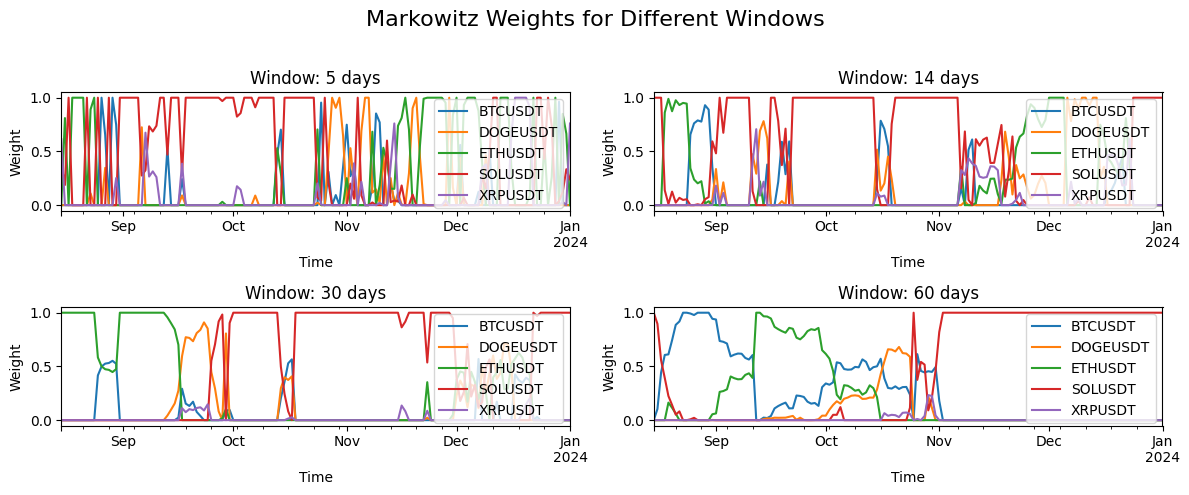

In [21]:

PredMVO1_windows = windows = [5, 14, 30, 60]
extra_days = [1, 5, 10]
PredMVO1 = []
PredMVO2 = []
PredMVO3 = []

# lmbda = 0.5

def get_PredMVO1_weights(window, extra_days):
    portfolio_weights = []
    for current_date in dfs[-1].index[dfs[-1].index >= start_date]:
        if current_date > pd.Timestamp('2023-12-31'): break
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]


        next_day = current_date + pd.Timedelta(days=1)
        new_row = pd.DataFrame([pred_close.loc[next_day]], index=[next_day])
        extra_data_up_to_today = pd.concat([data_up_to_today, new_row])

        # Calculate expected returns and covariance matrix using the latest data
        old_mean_returns = expected_returns.mean_historical_return(extra_data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        returns = extra_data_up_to_today.pct_change().dropna()
        n = len(returns) - 1

        # Define weights: N/(N+M) for each of the first N rows, M/(N+M) for the last
        M = extra_days
        N = n
        weights_array = np.full(N, 1 / (N + M))
        weights_array = np.append(weights_array, M / (N + M))  # last observation gets weight M/(N+M)

        # Normalize in case of numerical issues
        weights_array = weights_array / weights_array.sum()

        # Convert to DataFrame for alignment
        weights_series = pd.Series(weights_array, index=returns.index)

        # Weighted mean
        mu_weighted = returns.mul(weights_series, axis=0).sum()

        # Weighted covariance (bias-corrected)
        centered = returns - mu_weighted
        weighted_cov = centered.mul(weights_series, axis=0).T @ centered
        correction = 1 / (1 - np.sum(weights_array**2))
        cov_weighted = correction * weighted_cov

        mean_returns = expected_returns.mean_historical_return(pd.concat([data_up_to_today, *([new_row] * M)]), frequency=365)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        # ef = EfficientFrontier(mu_weighted, cov_weighted)
        # ef = EfficientFrontier(mu_weighted, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        # Calculate portfolio return using today's weights

        # Normalize portfolio weights to ensure they sum to 1
        weights_sum = sum(i for i in weights.values() if i >= 0)
        if weights_sum > 10:
            print(weights)
        if weights_sum != 0:
            weights = {key: max(0, value / weights_sum) for key, value in weights.items()}
        weights["day"] = next_day
        
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)
    print(M, old_mean_returns, mean_returns)
    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    return portfolio_weights

for window in PredMVO1_windows:
    PredMVO1.append(get_PredMVO1_weights(window, 1))
    PredMVO2.append(get_PredMVO1_weights(window, 5))
    PredMVO3.append(get_PredMVO1_weights(window, 10))


fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(PredMVO1):
        PredMVO1[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

NameError: name 'PredMVO1' is not defined

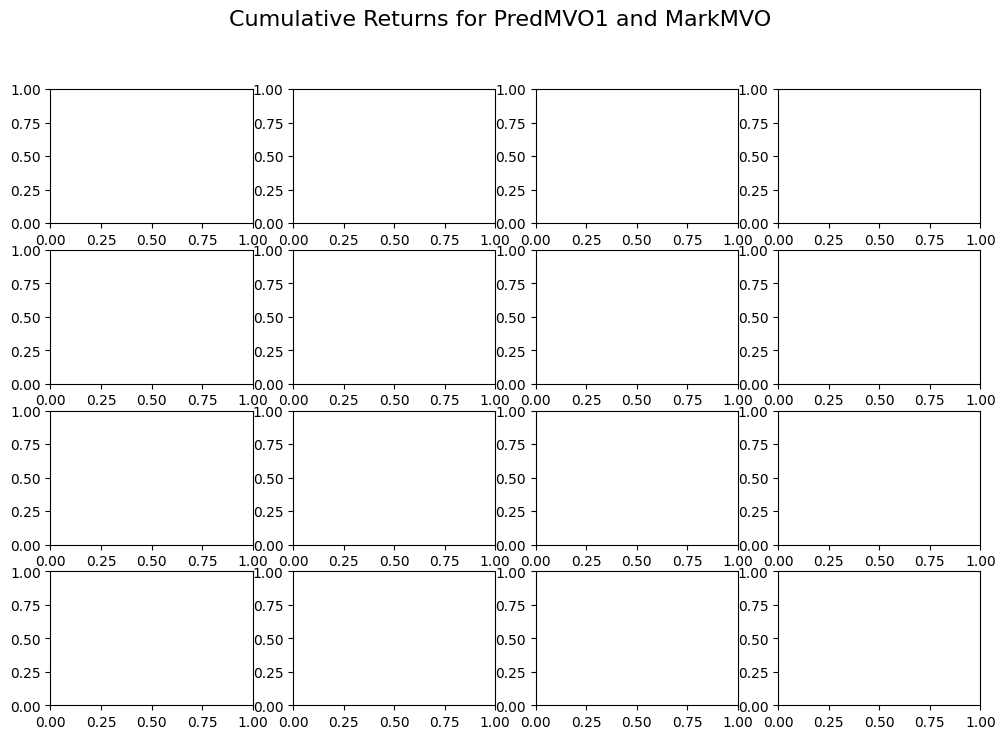

In [43]:
# Plot cumulative returns for each DataFrame in PredMVO1 and MarkMVO
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
fig.suptitle("Cumulative Returns for PredMVO1 and MarkMVO", fontsize=16)

for i, (df, ax) in enumerate(zip(PredMVO1 + PredMVO2 + PredMVO3 + MarkMVO, axes.flatten())):
    if i < len(PredMVO1):
        category = "PredMVO1"
        window = PredMVO1_windows[i % len(PredMVO1_windows)]
    elif i < len(PredMVO1) + len(PredMVO2):
        category = "PredMVO2"
        window = PredMVO1_windows[(i - len(PredMVO1)) % len(PredMVO1_windows)]
    elif i < len(PredMVO1) + len(PredMVO2) + len(PredMVO3):
        category = "PredMVO3"
        window = PredMVO1_windows[(i - len(PredMVO1) - len(PredMVO2)) % len(PredMVO1_windows)]
    else:
        category = "MarkMVO"
        window = MarkMVO_windows[(i - len(PredMVO1) - len(PredMVO2) - len(PredMVO3)) % len(MarkMVO_windows)]

    cumulative_returns = calculate_cumulative_returns(df)
    cumulative_returns["cumu"].plot(ax=ax, title=f"{category}\nWindow: {window} days")

    if cumulative_returns["port"].std() < 1e-15:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = cumulative_returns["port"].mean() / cumulative_returns["port"].std()
    ax.text(0.05, 0.95, f"Sharpe Ratio: {sharpe_ratio:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
